# Installing Libs

In [6]:
pip install textblob

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install afinn

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53439 sha256=716796b6e2f1e4e739f3f03954d27c3b9343c9b36fd39da262118cd9d9053070
  Stored in directory: c:\users\tzora\appdata\local\pip\cache\wheels\b0\05\90\43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'afinn' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'afinn'. Discussion can be found at https://github.com/pypa/pip/issues/6334


# Importing Libs

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from datasets import load_dataset
import openai
from huggingface_hub import login
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from transformers import Trainer
from transformers import TrainingArguments
from sentence_transformers import SentenceTransformer
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from transformers import BertTokenizer, BertModel
import nltk
import torch
from transformers import BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.auto import tqdm

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Importing Data

In [ ]:
login(token="TOKEN_HERE")
dataset = load_dataset('Ktzoras/shipping_features', split = 'train')
df = pd.DataFrame(dataset)
type(df.date.iloc[0])
del dataset


In [3]:
dataset = load_dataset('Ktzoras/shipping_llm_results_5k_sample', split = 'train')
training = pd.DataFrame(dataset)
del dataset

# Lexical Sentiment Analysis (LSA) 

## NLTK VADER 

In [4]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
scores = sia.polarity_scores("This is a great example!")
print(scores)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tzora\AppData\Roaming\nltk_data...


{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}


[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
def vader_score(text, sia=sia):
    
    scores = sia.polarity_scores(text)
    
    neg = scores['neg']
    pos = scores['pos']
    neu = scores['neu']
    compound = scores['compound']
    return pd.Series([neg, pos, neu, compound], index=['v_neg', 'v_pos', 'v_neu', 'v_compound'])


## TextBlob

In [166]:
from textblob import TextBlob
text = "This is a great example!"
blob = TextBlob(text)
print(blob.sentiment)  # polarity, subjectivity

Sentiment(polarity=1.0, subjectivity=0.75)


In [167]:
def textblob_score(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return pd.Series([polarity, subjectivity], index=['tb_polarity', 'tb_subjectivity'])

## SentiWordNet 

In [168]:
from nltk.corpus import sentiwordnet as swn
import nltk
nltk.download('sentiwordnet')
list(swn.senti_synsets('good'))[0].pos_score()

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\tzora\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


0.5

In [169]:
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def sentiwordnet_article_score(text):
    words = word_tokenize(text)
    pos_scores, neg_scores, obj_scores = [], [], []
    for word in words:
        synsets = list(swn.senti_synsets(word))
        if synsets:
            swn_synset = synsets[0]
            pos_scores.append(swn_synset.pos_score())
            neg_scores.append(swn_synset.neg_score())
            obj_scores.append(swn_synset.obj_score())
    # Avoid division by zero
    if pos_scores:
        avg_pos = np.mean(pos_scores)
        avg_neg = np.mean(neg_scores)
        avg_obj = np.mean(obj_scores)
    else:
        avg_pos, avg_neg, avg_obj = 0.0, 0.0, 0.0
    return pd.Series([avg_pos, avg_neg, avg_obj], index=['swn_pos', 'swn_neg', 'swn_obj'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tzora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## AFINN - (Finn Årup Nielsen.)

In [170]:
from afinn import Afinn
afinn = Afinn()
print(afinn.score("This is a great example!"))

3.0


In [171]:
def affin_score(text, afinn):

    score = afinn.score(text)
    return pd.Series([score], index=['afinn_score'])

# Sentiment Runs

## Vader

In [6]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb', 'pr_en_vessel_type_fe', 'pr_en_size_of_vessel_idfe',
       'pr_en_vessel_type_idrbfe', 'pr_en_vessel_type_rag',
       'pr_en_vessel_type_idfe', 'pr_en_route_idrbfe', 'pr_en_route_fe',
       'pr_en_size_of_vessel_rag', 'pr_en_size_of_vessel_fe',
       'pr_en_size_of_vessel_idrbfe', 'pr_en_impact_idfe', 'pr_en_route_rag',
       'pr_en_route_idfe', 'pr_en_scale_idfe', 'pr_en_duration_fe',
       'pr_en_duration_idrbfe', 'pr_en_scale_fe', 'pr_en_duration_rag',
       'pr_en_scale_idrbfe', 'pr_en_impact_rag', 'pr_en_scale_rag',
       'pr_en_impact_fe', 'pr_en_impact_idrbfe', 'pr_en_duration_idfe',
       'pr_en_impact_size_fe', 'pr_en_impact_size_idrbfe',
       'pr_en_impact_size_idfe', 'pr_en_impact_size_rag'],
      dtype='object')

In [7]:
sia = SentimentIntensityAnalyzer()
vader_scores = df['bart_summ'].apply(vader_score)

In [8]:
vader_scores.columns

Index(['v_neg', 'v_pos', 'v_neu', 'v_compound'], dtype='object')

In [9]:
df = pd.concat([df, vader_scores.reset_index(drop=True)], axis=1)

In [10]:
df

,link,date,title,content,led_summ,bart_summ,impact_idrbfe,sen_emb,sen_emb_mean,sen_emb_max,...,pr_en_impact_idrbfe,pr_en_duration_idfe,pr_en_impact_size_fe,pr_en_impact_size_idrbfe,pr_en_impact_size_idfe,pr_en_impact_size_rag,v_neg,v_pos,v_neu,v_compound
0,https://www.hellenicshippingnews.com/global-ln...,2025-04-18,Global LNG freight falls sharply as Bintulu LN...,Global LNG freight tumbled sharply April 16 as...,Global LNG freight tumbled sharply April 16 as...,Three of the nine trains at Bintulu LNG were t...,-1,"[-0.6256901025772095, -0.2969363331794739, -0....","[-0.6256901025772095, -0.2969363331794739, -0....","[-0.6256901025772095, -0.2969363331794739, -0....",...,-1,2,3,3,2,2,0.032,0.000,0.968,-0.2263
1,https://www.hellenicshippingnews.com/imos-net-...,2025-04-18,IMO’s net-zero strategy for global shipping st...,The IMO has adopted a framework that puts a pr...,The IMO has adopted a framework that puts a pr...,The IMO has adopted a framework that puts a pr...,0,"[-0.5662130117416382, -0.11961056292057037, 0....","[-0.5662130117416382, -0.11961056292057037, 0....","[-0.5662130117416382, -0.11961056292057037, 0....",...,0,12,0,0,2,3,0.000,0.091,0.909,0.7845
2,https://www.hellenicshippingnews.com/landmark-...,2025-04-18,Landmark IMO deal set to shake up shipping,A decisive moment for global shipping regulati...,", based on research by the International Counc...",The IMO Net-Zero Framework will combine mandat...,1,"[-0.5437169075012207, -0.13410450518131256, -0...","[-0.5437169075012207, -0.13410450518131256, -0...","[-0.5437169075012207, -0.13410450518131256, -0...",...,1,12,2,2,2,3,0.070,0.108,0.823,0.2500
3,https://www.hellenicshippingnews.com/russian-a...,2025-04-18,Russian Arctic oil exports to China jump helpe...,Russia’s Arctic oil exports to China are set t...,Russia’s Arctic oil exports to China are set t...,Arctic oil business accounts for a tenth of Ru...,-1,"[-0.774864137172699, -0.11404974013566971, -0....","[-0.774864137172699, -0.11404974013566971, -0....","[-0.774864137172699, -0.11404974013566971, -0....",...,-1,2,2,2,2,2,0.068,0.000,0.932,-0.5719
4,https://www.hellenicshippingnews.com/baltic-in...,2025-04-18,Baltic Index Rises On Strong Rates Across Vessels,The Baltic Exchange’s dry bulk sea freight ind...,The Baltic Exchange’s dry bulk sea freight ind...,The Baltic Exchange’s dry bulk sea freight ind...,1,"[-0.6020277142524719, -0.1214187741279602, 0.3...","[-0.6020277142524719, -0.1214187741279602, 0.3...","[-0.6020277142524719, -0.1214187741279602, 0.3...",...,1,2,1,1,2,2,0.048,0.097,0.855,0.5859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40008,https://www.hellenicshippingnews.com/venezuela...,2020-01-04,"Venezuela alters oil royalty formulas, driven ...",Venezuela has changed the formulas for calcula...,Venezuela has changed the formulas for calcula...,Venezuela has changed the formulas for calcula...,0,"[-0.6609678864479065, -0.02595953643321991, -0...","[-0.6609678864479065, -0.02595953643321991, -0...","[-0.6609678864479065, -0.02595953643321991, -0...",...,-1,2,2,2,2,4,0.154,0.061,0.785,-0.7579
40009,https://www.hellenicshippingnews.com/grindrod-...,2020-01-04,Grindrod Shipping Holdings Ltd. Announces Upda...,Grindrod Shipping Holdings Ltd. (GRIN) (GSH) (...,Grindrod Shipping Holdings Ltd. (GRIN) (GSH) (...,Grindrod Shipping is progressing negotiations ...,0,"[-0.5053577423095703, -0.1949986070394516, 0.2...","[-0.5053577423095703, -0.1949986070394516, 0.2...","[-0.5053577423095703, -0.1949986070394516, 0.2...",...,1,6,0,0,2,0,0.000,0.055,0.945,0.5994
40010,https://www.hellenicshippingnews.com/trans-pac...,2020-01-03,Trans-Pacific Market: CC3 Service Update,As part of APL’s continuous efforts to optimiz...,As part of APL’s continuous efforts to optimiz...,Revised port rotation on Central China Loop 3 ...,1,"[-0.7114651799201965, -0.25962769985198975, 0....","[-0.7114651799201965, -0.25962769985198975, 0....","[-0.7114651799201965, -0.25962769985198975,

## TextBlob

In [11]:
blob_scores = df['bart_summ'].apply(textblob_score)

NameError: name 'textblob_score' is not defined

In [176]:
df = pd.concat([df, blob_scores.reset_index(drop=True)], axis=1)

## SentiWordNet

In [177]:
df[['swn_pos', 'swn_neg', 'swn_obj']] = df['bart_summ'].apply(sentiwordnet_article_score)

## AFINN

In [178]:
df['affin_score'] = df['bart_summ'].apply(lambda x: affin_score(x, afinn))

# Analysis

In [237]:
df = df.drop(columns=[col for col in df.columns if col in ['v_neg', 'v_pos', 'v_neu', 'v_compound']], errors='ignore')

In [238]:
df.head()

,link,date,title,content,led_summ,bart_summ,impact_idrbfe,sen_emb,sen_emb_mean,sen_emb_max,...,sen_emb_concat,sen_emb_mix2,type_idrbfe,route_idrbfe,tb_polarity,tb_subjectivity,swn_pos,swn_neg,swn_obj,affin_score
0,https://www.hellenicshippingnews.com/global-ln...,2025-04-18,Global LNG freight falls sharply as Bintulu LN...,Global LNG freight tumbled sharply April 16 as...,Global LNG freight tumbled sharply April 16 as...,Three of the nine trains at Bintulu LNG were t...,-1,"[-0.6256901025772095, -0.2969363331794739, -0....","[-0.6256901025772095, -0.2969363331794739, -0....","[-0.6256901025772095, -0.2969363331794739, -0....",...,"[-0.6256901025772095, -0.2969363331794739, -0....","[-0.6256901025772095, -0.2969363331794739, -0....",0,0,-0.070139,0.190972,0.028846,0.022436,0.948718,-1.0
1,https://www.hellenicshippingnews.com/imos-net-...,2025-04-18,IMO’s net-zero strategy for global shipping st...,The IMO has adopted a framework that puts a pr...,The IMO has adopted a framework that puts a pr...,The IMO has adopted a framework that puts a pr...,0,"[-0.5662130117416382, -0.11961056292057037, 0....","[-0.5662130117416382, -0.11961056292057037, 0....","[-0.5662130117416382, -0.11961056292057037, 0....",...,"[-0.5662130117416382, -0.11961056292057037, 0....","[-0.5662130117416382, -0.11961056292057037, 0....",0,1,-0.041667,0.291667,0.014344,0.014344,0.971311,4.0
2,https://www.hellenicshippingnews.com/landmark-...,2025-04-18,Landmark IMO deal set to shake up shipping,A decisive moment for global shipping regulati...,", based on research by the International Counc...",The IMO Net-Zero Framework will combine mandat...,1,"[-0.5437169075012207, -0.13410450518131256, -0...","[-0.5437169075012207, -0.13410450518131256, -0...","[-0.5437169075012207, -0.13410450518131256, -0...",...,"[-0.5437169075012207, -0.13410450518131256, -0...","[-0.5437169075012207, -0.13410450518131256, -0...",0,1,0.197321,0.463393,0.026042,0.007812,0.966146,0.0
3,https://www.hellenicshippingnews.com/russian-a...,2025-04-18,Russian Arctic oil exports to China jump helpe...,Russia’s Arctic oil exports to China are set t...,Russia’s Arctic oil exports to China are set t...,Arctic oil business accounts for a tenth of Ru...,-1,"[-0.774864137172699, -0.11404974013566971, -0....","[-0.774864137172699, -0.11404974013566971, -0....","[-0.774864137172699, -0.11404974013566971, -0....",...,"[-0.774864137172699, -0.11404974013566971, -0....","[-0.774864137172699, -0.11404974013566971, -0....",0,0,-0.120000,0.380000,0.006098,0.027439,0.966463,-1.0
4,https://www.hellenicshippingnews.com/baltic-in...,2025-04-18,Baltic Index Rises On Strong Rates Across Vessels,The Baltic Exchange’s dry bulk sea freight ind...,The Baltic Exchange’s dry bulk sea freight ind...,The Baltic Exchange’s dry bulk sea freight ind...,1,"[-0.6020277142524719, -0.1214187741279602, 0.3...","[-0.6020277142524719, -0.1214187741279602, 0.3...","[-0.6020277142524719, -0.1214187741279602, 0.3...",...,"[-0.6020277142524719, -0.1214187741279602, 0.3...","[-0.6020277142524719, -0.1214187741279602, 0.3...",1,1,0.248889,0.554444,0.016204,0.023148,0.960648,3.0


In [ ]:
# from datasets import Dataset
# login(token="TOKEN_HERE")
# dataset = Dataset.from_pandas(df)
dataset.push_to_hub('shipping_news_articles_lsa')

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/930 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Ktzoras/shipping_news_articles_lsa/commit/de8a594d02b19a9106f047c99e3bec6e60afa089', commit_message='Upload dataset', commit_description='', oid='de8a594d02b19a9106f047c99e3bec6e60afa089', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Ktzoras/shipping_news_articles_lsa', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Ktzoras/shipping_news_articles_lsa'), pr_revision=None, pr_num=None)

# Regression

In [22]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', sep=',', encoding='utf-8')
c5.head()

,Date,c5,c3
0,1-Mar-99,3.10,5.44
1,2-Mar-99,3.03,5.50
2,3-Mar-99,3.10,5.54
3,4-Mar-99,3.11,5.52
4,5-Mar-99,3.15,5.52


In [23]:
# def fix_num(num):
#   return num.replace('.', '')[:-2]

c5['Date'] = pd.to_datetime(c5['Date'], format='%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)



In [21]:
# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method='bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)

In [24]:
c5_w.head()

Date
1999-03-07    3.11
1999-03-14    3.30
1999-03-21    3.61
1999-03-28    3.37
1999-04-04    3.35
Freq: W-SUN, Name: c5, dtype: float64

In [25]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb', 'pr_en_vessel_type_fe', 'pr_en_size_of_vessel_idfe',
       'pr_en_vessel_type_idrbfe', 'pr_en_vessel_type_rag',
       'pr_en_vessel_type_idfe', 'pr_en_route_idrbfe', 'pr_en_route_fe',
       'pr_en_size_of_vessel_rag', 'pr_en_size_of_vessel_fe',
       'pr_en_size_of_vessel_idrbfe', 'pr_en_impact_idfe', 'pr_en_route_rag',
       'pr_en_route_idfe', 'pr_en_scale_idfe', 'pr_en_duration_fe',
       'pr_en_duration_idrbfe', 'pr_en_scale_fe', 'pr_en_duration_rag',
       'pr_en_scale_idrbfe', 'pr_en_impact_rag', 'pr_en_scale_rag',
       'pr_en_impact_fe', 'pr_en_impact_idrbfe', 'pr_en_duration_idfe',
       'pr_en_impact_size_fe', 'pr_en_impact_size_idrbfe',
       'pr_en_impact_size_idfe', 'pr_en_impact_size_rag', 'v_neg', 'v_pos',
       'v_neu', 'v_compound'],
    

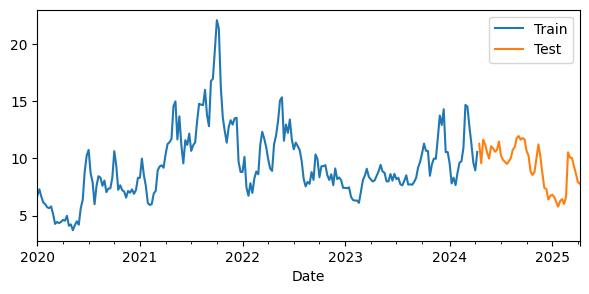

In [26]:
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=366)

test_start = df.date.max() - pd.Timedelta(days=365)
test_end = df.date.max()



c5_w = c5_w.loc[train_start:test_end]
train = c5_w.loc[train_start:train_end]
test = c5_w.loc[test_start:test_end]

fig, ax = plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label = "Train")
test.plot(ax=ax, label = "Test")
ax.legend()

## Vader

In [39]:
c5_w.head()

,c5
Date,
2020-01-05 00:00:00,6.73
2020-01-12 00:00:00,7.31
2020-01-19 00:00:00,6.68
2020-01-26 00:00:00,6.16
2020-02-02 00:00:00,6.0


In [45]:
v_neg.head()

date
2020-01-03    0.008000
2020-01-04    0.096625
2020-01-05    0.095000
2020-01-06    0.061687
2020-01-07    0.027690
Name: v_neg, dtype: float64

In [96]:
v_neg = df.groupby('date')['v_neg'].mean()
v_pos = df.groupby('date')['v_pos'].mean()
v_neu = df.groupby('date')['v_neu'].mean()
v_compound = df.groupby('date')['v_compound'].mean()

# Ensure all indices are datetime
v_neg.index = pd.to_datetime(v_neg.index)
v_pos.index = pd.to_datetime(v_pos.index)
v_neu.index = pd.to_datetime(v_neu.index)
v_compound.index = pd.to_datetime(v_compound.index)

v_neg_w = v_neg.asfreq('W', method='ffill')
v_pos_w = v_pos.asfreq('W', method='ffill')
v_neu_w = v_neu.asfreq('W', method='ffill')
v_compound_w = v_compound.asfreq('W', method='ffill')

# Always create a new DataFrame for features
c5_w_df = c5_w.to_frame(name='c5') if isinstance(c5_w, pd.Series) else c5_w.copy()
# Remove any non-date index values
c5_w_df = c5_w_df[pd.to_datetime(c5_w_df.index, errors='coerce').notna()]
c5_w_df.index = pd.to_datetime(c5_w_df.index)

# Now assign each column as a Series, not as a DataFrame
c5_w_df['v_neg'] = v_neg_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_pos'] = v_pos_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_neu'] = v_neu_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_compound'] = v_compound_w.reindex(c5_w_df.index, method='ffill')
c5_w_df[['v_neg', 'v_pos', 'v_neu', 'v_compound']] = c5_w_df[['v_neg', 'v_pos', 'v_neu', 'v_compound']].fillna(0)

print(c5_w_df.head())

              c5     v_neg     v_pos     v_neu  v_compound
Date                                                      
2020-01-05  6.73  0.095000  0.052000  0.852667   -0.071167
2020-01-12  7.31  0.000000  0.025000  0.975000    0.177900
2020-01-19  6.68  0.013500  0.085000  0.901500    0.629000
2020-01-26  6.16  0.000000  0.000000  1.000000    0.000000
2020-02-02   6.0  0.047188  0.082812  0.869938    0.156856


In [97]:
window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-3', 'c5_t-2', 'c5_t-1']]

# # only bdi
# X_train_bdi = X_train[['bdi_t-6', 'bdi_t-5', 'bdi_t-4', 'bdi_t-3', 'bdi_t-2', 'bdi_t-1']]
# X_test_bdi = X_test[['bdi_t-6', 'bdi_t-5', 'bdi_t-4', 'bdi_t-3', 'bdi_t-2', 'bdi_t-1']]


In [98]:
X_train

,c5_t-3,v_neg_t-3,v_pos_t-3,v_neu_t-3,v_compound_t-3,c5_t-2,v_neg_t-2,v_pos_t-2,v_neu_t-2,v_compound_t-2,c5_t-1,v_neg_t-1,v_pos_t-1,v_neu_t-1,v_compound_t-1
0,6.73,0.095,0.052,0.852667,-0.071167,7.31,0.0,0.025,0.975,0.1779,6.68,0.0135,0.085,0.9015,0.629
1,7.31,0.0,0.025,0.975,0.1779,6.68,0.0135,0.085,0.9015,0.629,6.16,0.0,0.0,1.0,0.0
2,6.68,0.0135,0.085,0.9015,0.629,6.16,0.0,0.0,1.0,0.0,6.0,0.047188,0.082812,0.869938,0.156856
3,6.16,0.0,0.0,1.0,0.0,6.0,0.047188,0.082812,0.869938,0.156856,5.74,0.038,0.063,0.8995,0.1806
4,6.0,0.047188,0.082812,0.869938,0.156856,5.74,0.038,0.063,0.8995,0.1806,5.66,0.023923,0.101692,0.797462,0.381838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,7.67,0.0595,0.0605,0.88,0.07035,8.76,0.0215,0.025,0.9535,0.0502,9.63,0.0455,0.0855,0.869,0.1929
213,8.76,0.0215,0.025,0.9535,0.0502,9.63,0.0455,0.0855,0.869,0.1929,9.76,0.191,0.0455,0.7635,-0.86665
214,9.63,0.0455,0.0855,0.869,0.1929,9.76,0.191,0.0455,0.7635,-0.86665,10.95,0.0,0.142,0.858,0.8074
215,9.76,0.191,0.0455,0.7635,-0.86665,10.95,0.0,0.142,0.858,0.8074,14.68,0.178,0.035,0.787,-0.886


In [99]:
y_train

array([ 6.08 ,  5.87 ,  5.7  ,  5.735,  5.465,  4.7  ,  4.365,  4.4  ,
        4.405,  4.545,  4.595,  4.775,  4.555,  4.18 ,  3.985,  3.945,
        4.335,  4.36 ,  4.93 ,  6.015,  7.61 ,  9.54 , 10.495,  9.735,
        8.33 ,  6.97 ,  6.805,  8.03 ,  8.385,  7.965,  7.84 ,  7.565,
        7.215,  7.38 ,  7.85 ,  9.475, 10.01 ,  8.32 ,  7.46 ,  7.445,
        7.17 ,  6.845,  6.87 ,  7.085,  7.155,  7.105,  7.085,  7.785,
        8.31 ,  9.15 ,  9.265,  8.07 ,  6.855,  6.02 ,  5.975,  6.48 ,
        7.05 ,  8.06 ,  9.13 ,  9.35 ,  9.295,  9.775, 10.81 , 11.34 ,
       11.565, 13.135, 14.775, 13.325, 12.67 , 12.425, 10.37 , 10.585,
       11.39 , 11.675, 11.415, 10.91 , 11.28 , 12.34 , 14.03 , 14.74 ,
       14.68 , 15.33 , 14.9  , 13.31 , 14.79 , 16.865, 18.27 , 20.825,
       21.72 , 18.8  , 14.92 , 12.995, 11.885, 12.06 , 13.04 , 13.15 ,
       13.23 , 13.53 , 11.645,  9.275,  8.82 ,  9.48 ,  8.805,  7.105,
        7.29 ,  7.415,  7.625,  8.56 ,  8.74 ,  9.905, 11.76 , 12.035,
      

In [100]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score


In [101]:
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}

In [102]:
pipelines = {
    name: Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])
    for name, model in reg_models.items()
}
results = []

In [103]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.060108  0.624567
1                      Ridge  Default        None  1.120504  0.580570
4                        SVR  Default        None  1.142717  0.563776
6  GradientBoostingRegressor  Default        None  1.299804  0.435599
7               XGBRegressor  Default        None  1.306411  0.429847
5      RandomForestRegressor  Default        None  1.348303  0.392695
8              LGBMRegressor  Default        None  1.369028  0.373881
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


In [104]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_c5, y_train)
    y_pred = pipe.predict(X_test_c5)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.040922  0.638034
1                      Ridge  Default        None  1.101820  0.594441
4                        SVR  Default        None  1.123532  0.578301
6  GradientBoostingRegressor  Default        None  1.375694  0.367769
5      RandomForestRegressor  Default        None  1.441674  0.305670
8              LGBMRegressor  Default        None  1.471572  0.276572
7               XGBRegressor  Default        None  1.532816  0.215104
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


In [59]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb', 'pr_en_vessel_type_fe', 'pr_en_size_of_vessel_idfe',
       'pr_en_vessel_type_idrbfe', 'pr_en_vessel_type_rag',
       'pr_en_vessel_type_idfe', 'pr_en_route_idrbfe', 'pr_en_route_fe',
       'pr_en_size_of_vessel_rag', 'pr_en_size_of_vessel_fe',
       'pr_en_size_of_vessel_idrbfe', 'pr_en_impact_idfe', 'pr_en_route_rag',
       'pr_en_route_idfe', 'pr_en_scale_idfe', 'pr_en_duration_fe',
       'pr_en_duration_idrbfe', 'pr_en_scale_fe', 'pr_en_duration_rag',
       'pr_en_scale_idrbfe', 'pr_en_impact_rag', 'pr_en_scale_rag',
       'pr_en_impact_fe', 'pr_en_impact_idrbfe', 'pr_en_duration_idfe',
       'pr_en_impact_size_fe', 'pr_en_impact_size_idrbfe',
       'pr_en_impact_size_idfe', 'pr_en_impact_size_rag', 'v_neg', 'v_pos',
       'v_neu', 'v_compound'],
    

In [92]:

v_compound = df.groupby('date')['v_compound'].mean()

# Ensure all indices are datetime

v_compound.index = pd.to_datetime(v_compound.index)


v_compound_w = v_compound.asfreq('W', method='ffill')

# Always create a new DataFrame for features
c5_w_df = c5_w.to_frame(name='c5') if isinstance(c5_w, pd.Series) else c5_w.copy()
# Remove any non-date index values
c5_w_df = c5_w_df[pd.to_datetime(c5_w_df.index, errors='coerce').notna()]
c5_w_df.index = pd.to_datetime(c5_w_df.index)

# Now assign each column as a Series, not as a DataFrame

c5_w_df['v_compound'] = v_compound_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_compound'] = c5_w_df['v_compound'].fillna(0)

window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-3', 'c5_t-2', 'c5_t-1']]


results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.032795  0.643663
1                      Ridge  Default        None  1.095315  0.599216
4                        SVR  Default        None  1.103388  0.593287
6  GradientBoostingRegressor  Default        None  1.332241  0.407078
5      RandomForestRegressor  Default        None  1.345189  0.395497
8              LGBMRegressor  Default        None  1.408566  0.337194
7               XGBRegressor  Default        None  1.480748  0.267522
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


In [95]:

v_compound = df.groupby('date')['v_compound'].sum()

# Ensure all indices are datetime

v_compound.index = pd.to_datetime(v_compound.index)


v_compound_w = v_compound.asfreq('W', method='ffill')

# Always create a new DataFrame for features
c5_w_df = c5_w.to_frame(name='c5') if isinstance(c5_w, pd.Series) else c5_w.copy()
# Remove any non-date index values
c5_w_df = c5_w_df[pd.to_datetime(c5_w_df.index, errors='coerce').notna()]
c5_w_df.index = pd.to_datetime(c5_w_df.index)

# Now assign each column as a Series, not as a DataFrame

c5_w_df['v_compound'] = v_compound_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_compound'] = c5_w_df['v_compound'].fillna(0)

window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-3', 'c5_t-2', 'c5_t-1']]


results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.062981  0.622529
1                      Ridge  Default        None  1.111197  0.587509
4                        SVR  Default        None  1.183960  0.531720
6  GradientBoostingRegressor  Default        None  1.312455  0.424559
5      RandomForestRegressor  Default        None  1.368714  0.374168
7               XGBRegressor  Default        None  1.379069  0.364663
8              LGBMRegressor  Default        None  1.381330  0.362578
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


In [107]:
v_neg = df.groupby('date')['v_neg'].sum()
v_pos = df.groupby('date')['v_pos'].sum()
v_neu = df.groupby('date')['v_neu'].sum()
v_compound = df.groupby('date')['v_compound'].sum()

# Ensure all indices are datetime
v_neg.index = pd.to_datetime(v_neg.index)
v_pos.index = pd.to_datetime(v_pos.index)
v_neu.index = pd.to_datetime(v_neu.index)
v_compound.index = pd.to_datetime(v_compound.index)

v_neg_w = v_neg.asfreq('W', method='ffill')
v_pos_w = v_pos.asfreq('W', method='ffill')
v_neu_w = v_neu.asfreq('W', method='ffill')
v_compound_w = v_compound.asfreq('W', method='ffill')

# Always create a new DataFrame for features
c5_w_df = c5_w.to_frame(name='c5') if isinstance(c5_w, pd.Series) else c5_w.copy()
# Remove any non-date index values
c5_w_df = c5_w_df[pd.to_datetime(c5_w_df.index, errors='coerce').notna()]
c5_w_df.index = pd.to_datetime(c5_w_df.index)

# Now assign each column as a Series, not as a DataFrame
c5_w_df['v_neg'] = v_neg_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_pos'] = v_pos_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_neu'] = v_neu_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_compound'] = v_compound_w.reindex(c5_w_df.index, method='ffill')
c5_w_df[['v_neg', 'v_pos', 'v_neu', 'v_compound']] = c5_w_df[['v_neg', 'v_pos', 'v_neu', 'v_compound']].fillna(0)

window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-3', 'c5_t-2', 'c5_t-1']]


results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.082270  0.608706
1                      Ridge  Default        None  1.119085  0.581633
4                        SVR  Default        None  1.275241  0.456729
8              LGBMRegressor  Default        None  1.351982  0.389376
7               XGBRegressor  Default        None  1.416764  0.329457
5      RandomForestRegressor  Default        None  1.424721  0.321904
6  GradientBoostingRegressor  Default        None  1.486800  0.261523
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


In [86]:
df['pr_en_route_idrbfe'].value_counts()

pr_en_route_idrbfe
0    25463
1    14550
Name: count, dtype: int64

In [87]:
df_filtered = df[df['pr_en_route_idrbfe'] == 1]
print(df_filtered.shape)

(14550, 47)


In [91]:
v_neg = df_filtered.groupby('date')['v_neg'].mean()
v_pos = df_filtered.groupby('date')['v_pos'].mean()
v_neu = df_filtered.groupby('date')['v_neu'].mean()
v_compound = df_filtered.groupby('date')['v_compound'].mean()

# Ensure all indices are datetime
v_neg.index = pd.to_datetime(v_neg.index)
v_pos.index = pd.to_datetime(v_pos.index)
v_neu.index = pd.to_datetime(v_neu.index)
v_compound.index = pd.to_datetime(v_compound.index)

v_neg_w = v_neg.asfreq('W', method='ffill')
v_pos_w = v_pos.asfreq('W', method='ffill')
v_neu_w = v_neu.asfreq('W', method='ffill')
v_compound_w = v_compound.asfreq('W', method='ffill')

# Always create a new DataFrame for features
c5_w_df = c5_w.to_frame(name='c5') if isinstance(c5_w, pd.Series) else c5_w.copy()
# Remove any non-date index values
c5_w_df = c5_w_df[pd.to_datetime(c5_w_df.index, errors='coerce').notna()]
c5_w_df.index = pd.to_datetime(c5_w_df.index)

# Now assign each column as a Series, not as a DataFrame
c5_w_df['v_neg'] = v_neg_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_pos'] = v_pos_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_neu'] = v_neu_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_compound'] = v_compound_w.reindex(c5_w_df.index, method='ffill')
c5_w_df[['v_neg', 'v_pos', 'v_neu', 'v_compound']] = c5_w_df[['v_neg', 'v_pos', 'v_neu', 'v_compound']].fillna(0)

window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-3', 'c5_t-2', 'c5_t-1']]


results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.135712  0.569108
4                        SVR  Default        None  1.239984  0.486354
1                      Ridge  Default        None  1.249657  0.478308
8              LGBMRegressor  Default        None  1.449613  0.298001
5      RandomForestRegressor  Default        None  1.467423  0.280646
6  GradientBoostingRegressor  Default        None  1.516848  0.231372
7               XGBRegressor  Default        None  1.708692  0.024652
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


In [105]:
v_neg = df_filtered.groupby('date')['v_neg'].sum()
v_pos = df_filtered.groupby('date')['v_pos'].sum()
v_neu = df_filtered.groupby('date')['v_neu'].sum()
v_compound = df_filtered.groupby('date')['v_compound'].sum()

# Ensure all indices are datetime
v_neg.index = pd.to_datetime(v_neg.index)
v_pos.index = pd.to_datetime(v_pos.index)
v_neu.index = pd.to_datetime(v_neu.index)
v_compound.index = pd.to_datetime(v_compound.index)

v_neg_w = v_neg.asfreq('W', method='ffill')
v_pos_w = v_pos.asfreq('W', method='ffill')
v_neu_w = v_neu.asfreq('W', method='ffill')
v_compound_w = v_compound.asfreq('W', method='ffill')

# Always create a new DataFrame for features
c5_w_df = c5_w.to_frame(name='c5') if isinstance(c5_w, pd.Series) else c5_w.copy()
# Remove any non-date index values
c5_w_df = c5_w_df[pd.to_datetime(c5_w_df.index, errors='coerce').notna()]
c5_w_df.index = pd.to_datetime(c5_w_df.index)

# Now assign each column as a Series, not as a DataFrame
c5_w_df['v_neg'] = v_neg_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_pos'] = v_pos_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_neu'] = v_neu_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_compound'] = v_compound_w.reindex(c5_w_df.index, method='ffill')
c5_w_df[['v_neg', 'v_pos', 'v_neu', 'v_compound']] = c5_w_df[['v_neg', 'v_pos', 'v_neu', 'v_compound']].fillna(0)

window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-3', 'c5_t-2', 'c5_t-1']]


results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.029491  0.645940
4                        SVR  Default        None  1.078757  0.611242
1                      Ridge  Default        None  1.105184  0.591961
5      RandomForestRegressor  Default        None  1.350598  0.390626
7               XGBRegressor  Default        None  1.365322  0.377267
6  GradientBoostingRegressor  Default        None  1.399310  0.345877
8              LGBMRegressor  Default        None  1.599512  0.145314
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


In [90]:
v_compound = df_filtered.groupby('date')['v_compound'].mean()


v_compound.index = pd.to_datetime(v_compound.index)


v_compound_w = v_compound.asfreq('W', method='ffill')

# Always create a new DataFrame for features
c5_w_df = c5_w.to_frame(name='c5') if isinstance(c5_w, pd.Series) else c5_w.copy()
# Remove any non-date index values
c5_w_df = c5_w_df[pd.to_datetime(c5_w_df.index, errors='coerce').notna()]
c5_w_df.index = pd.to_datetime(c5_w_df.index)


c5_w_df['v_compound'] = v_compound_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_compound'] = c5_w_df['v_compound'].fillna(0)

window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-3', 'c5_t-2', 'c5_t-1']]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.118164  0.582320
4                        SVR  Default        None  1.194213  0.523574
1                      Ridge  Default        None  1.224227  0.499325
8              LGBMRegressor  Default        None  1.411337  0.334584
5      RandomForestRegressor  Default        None  1.450434  0.297207
7               XGBRegressor  Default        None  1.562381  0.184533
6  GradientBoostingRegressor  Default        None  1.608419  0.135768
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


In [106]:
v_compound = df_filtered.groupby('date')['v_compound'].sum()


v_compound.index = pd.to_datetime(v_compound.index)


v_compound_w = v_compound.asfreq('W', method='ffill')

# Always create a new DataFrame for features
c5_w_df = c5_w.to_frame(name='c5') if isinstance(c5_w, pd.Series) else c5_w.copy()
# Remove any non-date index values
c5_w_df = c5_w_df[pd.to_datetime(c5_w_df.index, errors='coerce').notna()]
c5_w_df.index = pd.to_datetime(c5_w_df.index)


c5_w_df['v_compound'] = v_compound_w.reindex(c5_w_df.index, method='ffill')
c5_w_df['v_compound'] = c5_w_df['v_compound'].fillna(0)

window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-3', 'c5_t-2', 'c5_t-1']]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.035313  0.641924
4                        SVR  Default        None  1.094156  0.600064
1                      Ridge  Default        None  1.104957  0.592129
5      RandomForestRegressor  Default        None  1.263875  0.466370
7               XGBRegressor  Default        None  1.336581  0.403209
6  GradientBoostingRegressor  Default        None  1.345350  0.395352
8              LGBMRegressor  Default        None  1.661125  0.078200
3                 ElasticNet  Default        None  1.730333 -0.000211
2                      Lasso  Default        None  1.730333 -0.000211


## Vader Mix

In [326]:
v_neg = df.groupby('date')['v_neg'].mean()  # or .sum(), .mode()[0], etc.
v_pos = df.groupby('date')['v_pos'].mean()
v_neu = df.groupby('date')['v_neu'].mean()
v_compound = df.groupby('date')['v_compound'].mean()
impact_by_date = pd.DataFrame({'v_mix' : v_neg + v_pos + v_neu + v_compound})


# 2. Convert c5_w to DataFrame if not already
bdi_w_df = bdi_w.to_frame(name='bdi')
scaler = MinMaxScaler()
bdi_w_df['bdi'] = scaler.fit_transform(bdi_w_df[['bdi']])

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
bdi_w_df['v_mix'] = impact_by_date.v_mix.reindex(bdi_w_df.index, method='ffill')  # or method='nearest' if preferred


# 4. (Optional) Fill missing impact values with 0 or another value if needed
bdi_w_df['v_mix'] = bdi_w_df['v_mix'].fillna(0)



# Now c5_w_df has both 'c5' and 'impact' columns
print(bdi_w_df.head())

                 bdi     v_mix
Date                          
2020-01-05  0.085287  0.928500
2020-01-12  0.069726  1.177900
2020-01-19  0.062635  1.629000
2020-01-26  0.026591  1.000000
2020-02-02  0.010833  1.156794


In [327]:
window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = bdi_w_df.values  # shape: (num_weeks, num_features)
feature_names = bdi_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_bdi = X_train[['bdi_t-3', 'bdi_t-2', 'bdi_t-1']]
X_test_bdi = X_test[['bdi_t-3', 'bdi_t-2', 'bdi_t-1']]

# # only bdi
# X_train_bdi = X_train[['bdi_t-6', 'bdi_t-5', 'bdi_t-4', 'bdi_t-3', 'bdi_t-2', 'bdi_t-1']]
# X_test_bdi = X_test[['bdi_t-6', 'bdi_t-5', 'bdi_t-4', 'bdi_t-3', 'bdi_t-2', 'bdi_t-1']]


In [328]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.001369  0.759561
1                      Ridge  Default        None  0.001769  0.689360
5      RandomForestRegressor  Default        None  0.002207  0.612431
4                        SVR  Default        None  0.002211  0.611632
6  GradientBoostingRegressor  Default        None  0.002251  0.604674
8              LGBMRegressor  Default        None  0.002600  0.543313
7               XGBRegressor  Default        None  0.002729  0.520705
3                 ElasticNet  Default        None  0.008536 -0.499198
2                      Lasso  Default        None  0.008536 -0.499198


In [329]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_bdi, y_train)
    y_pred = pipe.predict(X_test_bdi)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.001368  0.759789
1                      Ridge  Default        None  0.001787  0.686182
4                        SVR  Default        None  0.001940  0.659207
8              LGBMRegressor  Default        None  0.002512  0.558842
6  GradientBoostingRegressor  Default        None  0.002532  0.555305
5      RandomForestRegressor  Default        None  0.002906  0.489682
7               XGBRegressor  Default        None  0.003924  0.310914
3                 ElasticNet  Default        None  0.008536 -0.499198
2                      Lasso  Default        None  0.008536 -0.499198


## Vader positive

In [334]:
# or .sum(), .mode()[0], etc.
v_pos = df.groupby('date')['v_pos'].mean()
v_neg = df.groupby('date')['v_neg'].mean() 
v_compound = df.groupby('date')['v_compound'].mean()
impact_by_date = pd.DataFrame({'v_pos' : v_pos + v_neg})


# 2. Convert c5_w to DataFrame if not already
bdi_w_df = bdi_w.to_frame(name='bdi')
scaler = MinMaxScaler()
bdi_w_df['bdi'] = scaler.fit_transform(bdi_w_df[['bdi']])

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
bdi_w_df['v_pos'] = impact_by_date.v_pos.reindex(bdi_w_df.index, method='ffill')  # or method='nearest' if preferred


# 4. (Optional) Fill missing impact values with 0 or another value if needed
bdi_w_df['v_pos'] = bdi_w_df['v_pos'].fillna(0)



# Now c5_w_df has both 'c5' and 'impact' columns
print(bdi_w_df.head())

                 bdi   v_pos
Date                        
2020-01-05  0.085287  0.1470
2020-01-12  0.069726  0.0250
2020-01-19  0.062635  0.0985
2020-01-26  0.026591  0.0000
2020-02-02  0.010833  0.1300


In [335]:
window_size = 3  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = bdi_w_df.values  # shape: (num_weeks, num_features)
feature_names = bdi_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_bdi = X_train[['bdi_t-3', 'bdi_t-2', 'bdi_t-1']]
X_test_bdi = X_test[['bdi_t-3', 'bdi_t-2', 'bdi_t-1']]

# # only bdi
# X_train_bdi = X_train[['bdi_t-6', 'bdi_t-5', 'bdi_t-4', 'bdi_t-3', 'bdi_t-2', 'bdi_t-1']]
# X_test_bdi = X_test[['bdi_t-6', 'bdi_t-5', 'bdi_t-4', 'bdi_t-3', 'bdi_t-2', 'bdi_t-1']]


In [336]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.001394  0.755175
1                      Ridge  Default        None  0.001798  0.684269
4                        SVR  Default        None  0.001988  0.650775
8              LGBMRegressor  Default        None  0.002286  0.598587
5      RandomForestRegressor  Default        None  0.002388  0.580626
6  GradientBoostingRegressor  Default        None  0.002499  0.561164
7               XGBRegressor  Default        None  0.003054  0.463718
3                 ElasticNet  Default        None  0.008536 -0.499198
2                      Lasso  Default        None  0.008536 -0.499198


## C5

In [333]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()

,Date,c5,c3
0,1-Mar-99,3.10,5.44
1,2-Mar-99,3.03,5.50
2,3-Mar-99,3.10,5.54
3,4-Mar-99,3.11,5.52
4,5-Mar-99,3.15,5.52


In [263]:
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format='%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method='bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)

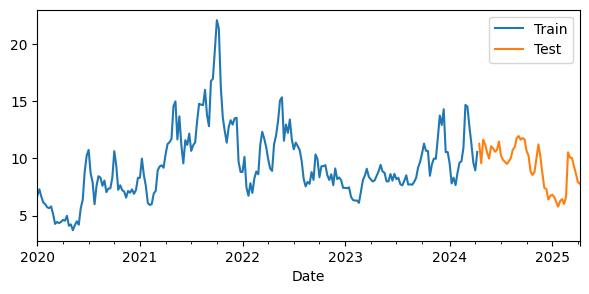

In [264]:
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=366)

test_start = df.date.max() - pd.Timedelta(days=365)
test_end = df.date.max()



c5_w = c5_w.loc[train_start:test_end]
train = c5_w.loc[train_start:train_end]
test = c5_w.loc[test_start:test_end]

fig, ax = plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label = "Train")
test.plot(ax=ax, label = "Test")
ax.legend()

In [266]:
# or .sum(), .mode()[0], etc.
v_pos = df.groupby('date')['v_pos'].mean()
v_compound = df.groupby('date')['v_compound'].mean()
impact_by_date = pd.DataFrame({'v_pos' : v_pos})
# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)

# Now c5_w_df has both 'c5' and 'impact' columns
print(c5_w_df.head())

              c5    impact
Date                      
2020-01-05  6.73  0.052000
2020-01-12  7.31  0.025000
2020-01-19  6.68  0.085000
2020-01-26  6.16  0.000000
2020-02-02  6.00  0.082812


In [267]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-6', 'c5_t-5', 'c5_t-4', 'c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-6', 'c5_t-5', 'c5_t-4', 'c5_t-3', 'c5_t-2', 'c5_t-1']]

In [268]:
X_train

,c5_t-6,impact_t-6,c5_t-5,impact_t-5,c5_t-4,impact_t-4,c5_t-3,impact_t-3,c5_t-2,impact_t-2,c5_t-1,impact_t-1
0,6.73,0.052000,7.31,0.025000,6.68,0.085000,6.16,0.000000,6.00,0.082812,5.74,0.063000
1,7.31,0.025000,6.68,0.085000,6.16,0.000000,6.00,0.082812,5.74,0.063000,5.66,0.101692
2,6.68,0.085000,6.16,0.000000,6.00,0.082812,5.74,0.063000,5.66,0.101692,5.81,0.105500
3,6.16,0.000000,6.00,0.082812,5.74,0.063000,5.66,0.101692,5.81,0.105500,5.12,0.000000
4,6.00,0.082812,5.74,0.063000,5.66,0.101692,5.81,0.105500,5.12,0.000000,4.28,0.073933
...,...,...,...,...,...,...,...,...,...,...,...,...
210,7.82,0.053600,8.32,0.092667,7.67,0.060500,8.76,0.025000,9.63,0.085500,9.76,0.045500
211,8.32,0.092667,7.67,0.060500,8.76,0.025000,9.63,0.085500,9.76,0.045500,10.95,0.142000
212,7.67,0.060500,8.76,0.025000,9.63,0.085500,9.76,0.045500,10.95,0.142000,14.68,0.035000
213,8.76,0.025000,9.63,0.085500,9.76,0.045500,10.95,0.142000,14.68,0.035000,14.54,0.109133


In [269]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
1                      Ridge  Default        None  0.980996  0.676141
3                 ElasticNet  Default        None  1.003728  0.668636
2                      Lasso  Default        None  1.032837  0.659026
0           LinearRegression  Default        None  1.144778  0.622071
4                        SVR  Default        None  1.188425  0.607662
6  GradientBoostingRegressor  Default        None  1.424303  0.529791
8              LGBMRegressor  Default        None  1.638341  0.459129
5      RandomForestRegressor  Default        None  1.853360  0.388145
7               XGBRegressor  Default        None  2.151398  0.289753


In [270]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_c5, y_train)
    y_pred = pipe.predict(X_test_c5)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
1                      Ridge  Default        None  0.960437  0.682928
0           LinearRegression  Default        None  0.961015  0.682737
3                 ElasticNet  Default        None  1.003728  0.668636
2                      Lasso  Default        None  1.032837  0.659026
4                        SVR  Default        None  1.156972  0.618045
6  GradientBoostingRegressor  Default        None  1.578443  0.478904
5      RandomForestRegressor  Default        None  1.670717  0.448441
7               XGBRegressor  Default        None  1.898587  0.373214
8              LGBMRegressor  Default        None  2.112331  0.302650


# Subset relevant

In [271]:
X_sen_mean = df['sen_emb_mean']
X_sen_max = df['sen_emb_max']
X_sen_mix = df['sen_emb_mix']
X_sen_sum = df['sen_emb_sum']
X_sen_concat = df['sen_emb_concat']
X_sen_mix2 = df['sen_emb_mix2']

In [272]:
train_x, test_x, train_y, test_y = train_test_split(X_sen_mean[:2000], training['Impact_idrbfe'], test_size=0.2, random_state=42, stratify = training['Impact_idrbfe'])
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1600,), (400,), (1600,), (400,))

In [273]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'type_idrbfe', 'route_idrbfe', 'tb_polarity', 'tb_subjectivity',
       'swn_pos', 'swn_neg', 'swn_obj', 'affin_score', 'v_neg', 'v_pos',
       'v_neu', 'v_compound'],
      dtype='object')

In [283]:
def proc_route(route):
    if route in ['All', 'C5', 'C3']:
        return 1
    else:
        return 0

In [284]:
def proc_vessel_type(vessel_type):
    if vessel_type in ['Dry', 'Bulk Carrier', 'All']:
        return 1
    else:
        return 0

In [285]:
training['Type of Vessel_idrbfe'] = training['Type of Vessel_idrbfe'].apply(proc_vessel_type)

In [286]:
training['Sea Route_idrbfe'] = training['Sea Route_idrbfe'].apply(proc_route)

In [287]:
training['Type of Vessel_idrbfe'].head()

0    0
1    0
2    0
3    0
4    1
Name: Type of Vessel_idrbfe, dtype: int64

In [288]:
# Vesel Type

model = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
train_x_sen_mean, test_x_sen_mean, train_y, test_y = train_test_split(X_sen_mean[:2000], training['Type of Vessel_idrbfe'], test_size=0.2, random_state=42, stratify = training['Type of Vessel_idrbfe'])

train_x_sen_mean = np.vstack(train_x_sen_mean.values)
test_x_sen_mean = np.vstack(test_x_sen_mean.values)

grid = GridSearchCV(model, param_grid, cv = 3, scoring = 'f1_weighted', n_jobs = -1)
grid.fit(train_x_sen_mean, train_y)
best_model = grid.best_estimator_

all_embeddings = np.array(df.sen_emb.tolist())
df['type_idrbfe'] = best_model.predict(all_embeddings)

In [289]:
# Route

model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
train_x_sen_mean, test_x_sen_mean, train_y, test_y = train_test_split(X_sen_mean[:2000], training['Sea Route_idrbfe'], test_size=0.2, random_state=42, stratify = training['Sea Route_idrbfe'])

train_x_sen_mean = np.vstack(train_x_sen_mean.values)
test_x_sen_mean = np.vstack(test_x_sen_mean.values)

grid = GridSearchCV(model, param_grid, cv = 3, scoring = 'f1_weighted', n_jobs = -1)
grid.fit(train_x_sen_mean, train_y)
best_model = grid.best_estimator_

all_embeddings = np.array(df.sen_emb.tolist())
df['route_idrbfe'] = best_model.predict(all_embeddings)

In [290]:
subset = df[(df['type_idrbfe'] == 1) & (df['route_idrbfe'] == 1)]

## Run

In [291]:
# or .sum(), .mode()[0], etc.
v_pos = subset.groupby('date')['v_pos'].mean()
v_compound = subset.groupby('date')['v_compound'].mean()
impact_by_date = pd.DataFrame({'v_pos' : v_pos})
# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)

# Now c5_w_df has both 'c5' and 'impact' columns
print(c5_w_df.head())

              c5  impact
Date                    
2020-01-05  6.73   0.000
2020-01-12  7.31   0.051
2020-01-19  6.68   0.067
2020-01-26  6.16   0.000
2020-02-02  6.00   0.000


In [292]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# only bdi
X_train_c5 = X_train[['c5_t-6', 'c5_t-5', 'c5_t-4', 'c5_t-3', 'c5_t-2', 'c5_t-1']]
X_test_c5 = X_test[['c5_t-6', 'c5_t-5', 'c5_t-4', 'c5_t-3', 'c5_t-2', 'c5_t-1']]

In [293]:
X_train.columns

Index(['c5_t-6', 'impact_t-6', 'c5_t-5', 'impact_t-5', 'c5_t-4', 'impact_t-4',
       'c5_t-3', 'impact_t-3', 'c5_t-2', 'impact_t-2', 'c5_t-1', 'impact_t-1'],
      dtype='object')

In [294]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
1                      Ridge  Default        None  1.003008  0.668874
3                 ElasticNet  Default        None  1.003728  0.668636
2                      Lasso  Default        None  1.032837  0.659026
0           LinearRegression  Default        None  1.158950  0.617392
4                        SVR  Default        None  1.188668  0.607582
6  GradientBoostingRegressor  Default        None  1.380733  0.544175
5      RandomForestRegressor  Default        None  1.510116  0.501461
7               XGBRegressor  Default        None  1.534490  0.493414
8              LGBMRegressor  Default        None  1.818789  0.399558


In [295]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_c5, y_train)
    y_pred = pipe.predict(X_test_c5)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
1                      Ridge  Default        None  0.960437  0.682928
0           LinearRegression  Default        None  0.961015  0.682737
3                 ElasticNet  Default        None  1.003728  0.668636
2                      Lasso  Default        None  1.032837  0.659026
4                        SVR  Default        None  1.156972  0.618045
6  GradientBoostingRegressor  Default        None  1.578443  0.478904
5      RandomForestRegressor  Default        None  1.670717  0.448441
7               XGBRegressor  Default        None  1.898587  0.373214
8              LGBMRegressor  Default        None  2.112331  0.302650


In [297]:
ols = LinearRegression()
ols.fit(X_train_c5, y_train)
y_pred = ols.predict(X_test_c5)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"OLS MSE: {mse}, R2: {r2}")

OLS MSE: 0.9610151823449934, R2: 0.6827371559929662


In [298]:
ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred = ols.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"OLS MSE: {mse}, R2: {r2}")

OLS MSE: 1.1589501162570301, R2: 0.6173922985807827


In [299]:
c5_w_df

,c5,impact
Date,,
2020-01-05,6.73,0.000
2020-01-12,7.31,0.051
2020-01-19,6.68,0.067
2020-01-26,6.16,0.000
2020-02-02,6.00,0.000
...,...,...
2025-03-16,10.04,0.101
2025-03-23,9.33,0.000
2025-03-30,8.68,0.032


In [300]:
from statsmodels.tsa.stattools import grangercausalitytests

In [301]:
data = c5_w_df[['c5', 'impact']].dropna()
grangercausalitytests(data[['c5', 'impact']], maxlag=8, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1950  , p=0.6592  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=0.1971  , p=0.6571  , df=1
likelihood ratio test: chi2=0.1970  , p=0.6571  , df=1
parameter F test:         F=0.1950  , p=0.6592  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1734  , p=0.3109  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=2.3904  , p=0.3026  , df=2
likelihood ratio test: chi2=2.3800  , p=0.3042  , df=2
parameter F test:         F=1.1734  , p=0.3109  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2765  , p=0.2828  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=3.9302  , p=0.2691  , df=3
likelihood ratio test: chi2=3.9022  , p=0.2722  , df=3
parameter F test:         F=1.2765  , p=0.2828  , df_denom=266, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2195  , p=0.3029  

{np.int64(1): ({'ssr_ftest': (np.float64(0.1949560130005994),
    np.float64(0.6591741891417049),
    np.float64(272.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.19710626314398835),
    np.float64(0.6570667961096553),
    np.int64(1)),
   'lrtest': (np.float64(0.19703565891722974),
    np.float64(0.6571242918984113),
    np.int64(1)),
   'params_ftest': (np.float64(0.19495601300056314),
    np.float64(0.6591741891417544),
    np.float64(272.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.1733971009833832),
    np.float64(0.31089245346121963),
    np.float64(269.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.3904149120404985),
    np.float64(0.30264116293793053),
    np.int64(2)),
   'lrtest': (np.float64(2.3800480037448324),
    np.float64(0.30421396227436626),
    np.int64(2)),
   'params_ftest': (np.float64(1.1733971009833772),
    np.float64(0.31089245346121963),
    np.float64(269.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],

## NLTK VADER 